In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv("information.csv")
feature_names = ['NDVI', 'Drought', 'Elevation', 'DSMP', 'Population', 'Radiation', 'Precipitation','Temperature', 'Production']
#feature_names = ['NDVI', 'Drought', 'DSMP', 'Population', 'Radiation', 'Precipitation','Temperature', 'Production','Fragmentation']
label = "Landcover"
X = df[feature_names]
y = df[label]

In [3]:
print(y)

0           4
1           4
2           4
3           4
4           4
           ..
29083906    1
29083907    1
29083908    1
29083909    1
29083910    1
Name: Landcover, Length: 29083911, dtype: int64


In [4]:
#We replace it in order to not have nan
X.replace([np.inf, -np.inf], np.nan, inplace=True)


C:\Users\admin\AppData\Local\Temp\ipykernel_3924\403450470.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.replace([np.inf, -np.inf], np.nan, inplace=True)


In [5]:
#We fill the nan with the mean of the data
X.fillna(X.mean(), inplace=True)

C:\Users\admin\AppData\Local\Temp\ipykernel_3924\642802493.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.fillna(X.mean(), inplace=True)


In [6]:
#We check that there are not nan or inf values
assert np.isinf(X).sum().sum() == 0, "Todavía hay valores infinitos en X"
assert np.isnan(X).sum().sum() == 0, "Todavía hay valores NaN en X"

In [7]:
#We select the 80% of the variables that have more F_value
from sklearn.feature_selection import SelectPercentile, f_classif
print(X.shape)
f_statistic, p_values = f_classif(X, y)
X_new = SelectPercentile(f_classif, percentile=80).fit_transform(X, y)
print(X_new.shape)
print(X_new[0])
feature_names = ['NDVI', 'Drought', 'Elevation', 'DSMP', 'Population', 'Radiation', 'Precipitation','Temperature', 'Production','Fragmentation']


(29083911, 9)


c:\Users\admin\anaconda3\envs\rasterio_env\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning: Features [5] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\admin\anaconda3\envs\rasterio_env\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
c:\Users\admin\anaconda3\envs\rasterio_env\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning: Features [5] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\admin\anaconda3\envs\rasterio_env\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


(29083911, 7)
[ 0.      0.      1.137   0.      0.3584 24.16    0.    ]


In [10]:
#Show the f-statistic and the p-value
for i in range(len(f_statistic)):
    print(feature_names[i]+" tiene un f-statistic de "+str(f_statistic[i]))
    print(feature_names[i]+" tiene un p_valor de "+str(p_values[i]))
print(f_statistic)
print(p_values)

NDVI tiene un f-statistic de 6992047.134648701
NDVI tiene un p_valor de 0.0
Drought tiene un f-statistic de 803601.2025171265
Drought tiene un p_valor de 0.0
Elevation tiene un f-statistic de 1327250.0211014305
Elevation tiene un p_valor de 0.0
DSMP tiene un f-statistic de 2333959.779112956
DSMP tiene un p_valor de 0.0
Population tiene un f-statistic de 10728220.717562119
Population tiene un p_valor de 0.0
Radiation tiene un f-statistic de nan
Radiation tiene un p_valor de nan
Precipitation tiene un f-statistic de 4213501.089090898
Precipitation tiene un p_valor de 0.0
Temperature tiene un f-statistic de 4614207.332872801
Temperature tiene un p_valor de 0.0
Production tiene un f-statistic de 2548411.6727538933
Production tiene un p_valor de 0.0
[ 6992047.1346487    803601.20251713  1327250.02110143  2333959.77911296
 10728220.71756212               nan  4213501.0890909   4614207.3328728
  2548411.67275389]
[ 0.  0.  0.  0.  0. nan  0.  0.  0.]


In [8]:
from sklearn.model_selection import train_test_split

In [9]:
#we do a new sample, with the same percentage in the y variable

sample_size = 0.1

# Realizar el muestreo estratificado
X_sampled, _, y_sampled, _ = train_test_split(X_new, y, train_size=sample_size, stratify=y, random_state=42)

In [10]:
print(y_sampled)

10995476    3
10287941    2
15280778    4
19008027    3
7028805     3
           ..
16001833    2
19116143    2
26745869    1
482101      4
15791550    2
Name: Landcover, Length: 2908391, dtype: int64


In [10]:
#We train the random forest

from sklearn import ensemble

n_trees=300
random_seed = 42 
rf = ensemble.RandomForestClassifier(n_trees)

In [11]:
X_new = X_new.astype(np.int16)

In [13]:
#We train the random forest with our data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_sampled, y_sampled, test_size=0.2, random_state=42)
n_trees = 300
random_seed = 42
rf = ensemble.RandomForestClassifier(n_trees).fit(X_train, y_train)

In [14]:
len(y_sampled)

2908391

In [15]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

#We shuffle the data before the validation because the rows with the same landcover are very close one to each other
kf=KFold(n_splits=5, random_state=42, shuffle=True)
print("Ya ha hecho el primero")
scores_shuffle = cross_val_score(rf, X_sampled, y_sampled, cv=kf)

Ya ha hecho el primero


In [17]:
print(scores_shuffle)
print(np.mean(scores_shuffle))

[0.9091492  0.90878802 0.90916452 0.90953758 0.90892728]
0.9091133207206721


In [16]:
#We made the prediction using the cross validation
from sklearn.model_selection import cross_val_predict
y_pred=cross_val_predict(rf, X_sampled, y_sampled, cv=kf)

In [32]:
print(len(y_sampled))

2908391


In [56]:
#We do the confusion matrix

etiqueta2=['forest', 'cropland', 'grassland', 'waterbody', 'built_up']

forest_pred=[0 for k in range(5)]
crop_pred=[0 for k in range(5)]
grass_pred=[0 for k in range(5)]
water_pred=[0 for k in range(5)]
built_pred=[0 for k in range(5)]

for i in range(0, 2908391):
    for j in [1,2,3,4,5]:        
        if y_sampled.iloc[i]==j:
            if y_pred[i]==1:  
                forest_pred[j-1]+=1
            elif y_pred[i]==2:
                crop_pred[j-1]+=1
            elif y_pred[i]==3:
                grass_pred[j-1]+=1
            elif y_pred[i]==4:
                water_pred[j-1]+=1
            elif y_pred[i]==5:
                built_pred[j-1]+=1
            
print("Matriz de confusion")

print(forest_pred)
print(crop_pred)
print(grass_pred)
print(water_pred)
print(built_pred)

#416096

Matriz de confusion
[358726, 19801, 35345, 3766, 5]
[17836, 745512, 57335, 4273, 313]
[33166, 67490, 1317906, 7866, 127]
[3359, 4568, 8733, 218308, 106]
[4, 164, 46, 70, 3566]


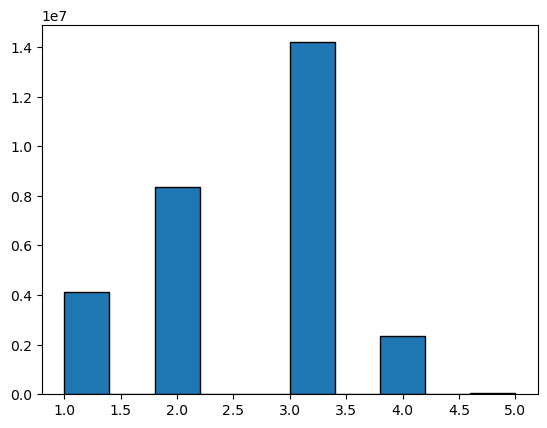

In [19]:
#We do the histogram of the y variable

import matplotlib.pyplot as plt
plt.hist(y, bins=10, edgecolor='black')
plt.show()